In [1]:
import sys
sys.path.append("../codesearchnet")


import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import os.path as osp


# import torch
# import torch.nn.functional as F
# from torch_geometric.datasets import Planetoid
# import torch_geometric.transforms as T
# from torch_geometric.nn import GCNConv, GAE, VGAE
# from torch_geometric.utils import train_test_split_edges


import swifter
import fasttext as ft
import numpy as np
import networkx as nx
from livelossplot import PlotLosses
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, LSTM, Embedding, Bidirectional
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


from code_parser import *
from data_reader import get_data_df

In [3]:
embeddings_dim_c, embeddings_dim_q = 128, 128
max_len_code, max_len_query = 128, 64
vocab_size_code = 100000
vocab_size_query = 50000

In [4]:
batch_size = 54

In [ ]:
def get_dataset(split):
    df = get_data_df("../resources/data/", ["python"] , [split])
    
    array_querys = np.array(df['docstring_tokens'].apply(lambda x : " ".join(x)))
    array_codes = np.array(df['code_tokens'].apply(lambda x : " ".join(x)))
    
    query_dataset = tf.data.Dataset.from_tensor_slices(array_querys)
    code_dataset = tf.data.Dataset.from_tensor_slices(array_codes)
    
    dataset = tf.data.Dataset.zip((query_dataset, code_dataset)).batch(batch_size)
    
    return dataset

In [29]:
df = get_data_df("../resources/data/", ["python"] , ["test"])

4    def dailymotion_download(url, output_dir='.', ...
Name: code, dtype: object

## Custom tokenisation

In [ ]:
train_ds = get_dataset("train")
valid_ds = get_dataset("valid")
test_ds = get_dataset("test")

In [ ]:
vectorize_code = TextVectorization(
    standardize=None,
    max_tokens=vocab_size_code,
    output_mode="int",
    output_sequence_length=max_len_code,
)

vectorize_query = TextVectorization(
    max_tokens=vocab_size_query,
    output_mode="int",
    output_sequence_length=max_len_query,
)

In [ ]:
vectorize_code.adapt(train_ds.map(lambda q,c: c))
vectorize_query.adapt(train_ds.map(lambda q,c: q))

In [ ]:
def vectorize(query, code):
    query = tf.expand_dims(query, -1)
    code = tf.expand_dims(code, -1)
    return vectorize_query(query), vectorize_code(code)

In [ ]:
train_ds = train_ds.map(vectorize)
valid_ds = valid_ds.map(vectorize)
test_ds = test_ds.map(vectorize)

In [ ]:
train_ds = train_ds.prefetch(buffer_size=10)
valid_ds = valid_ds.prefetch(buffer_size=10)
test_ds = test_ds.prefetch(buffer_size=10)

## Model

In [ ]:
loss_tracker = tf.keras.metrics.Mean(name="loss")
mrr_tracker = tf.keras.metrics.Mean(name="mrr")

class CustomModel(tf.keras.Model):
    def train_step(self, data):
        with tf.GradientTape() as tape:
            logits = self(data, training=True)
            loss_value = loss_(None, logits)
        
        mrr_value = mrr(None, logits)

        gradients = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Compute our own metrics
        loss_tracker.update_state(loss_value)
        mrr_tracker.update_state(mrr_value)
        return {"loss": loss_tracker.result(), "mrr": mrr_tracker.result()}
    
    def test_step(self, data):
            
        logits = self(data, training=False)
        loss_value = loss_(None, logits)
        mrr_value = mrr(None, logits)
        
        
        loss_tracker.update_state(loss_value)
        mrr_tracker.update_state(mrr_value)
        return {"loss": loss_tracker.result(), "mrr": mrr_tracker.result()}

In [ ]:
input_query = tf.keras.Input(shape=(None,), dtype="int64")
input_q = Embedding(len(vectorize_query.get_vocabulary()) + 1, embeddings_dim_q)(input_query)

input_code = tf.keras.Input(shape=(None,), dtype="int64")
input_c = Embedding(len(vectorize_code.get_vocabulary()) + 1, embeddings_dim_c)(input_code)

lstm_q = LSTM(embeddings_dim_q, dropout=0.3, recurrent_dropout=0.0)(input_q)
lstm_c = LSTM(embeddings_dim_c, dropout=0.3, recurrent_dropout=0.0)(input_c)


model = CustomModel([input_query, input_code], [lstm_q, lstm_c])

In [ ]:
def loss_(y_true, y_pred):
    
    q, c = y_pred

    similarity_score = tf.matmul(q, K.transpose(c))
    per_sample_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=similarity_score,
        labels=tf.range(q.shape[0])
    )
    return tf.reduce_sum(per_sample_loss) / q.shape[0]

In [ ]:

def mrr(y_true, y_pred):
    q,c = y_pred
    
    similarity_scores = tf.matmul(q, K.transpose(c))
    
    # extract the logits from the diagonal of the matrix, which are the logits corresponding to the ground-truth
    correct_scores = tf.linalg.diag_part(similarity_scores)
    
    # compute how many queries have bigger logits than the ground truth (the diagonal) -> which will be incorrectly ranked
    compared_scores = similarity_scores >= tf.expand_dims(correct_scores, axis=-1)
    
    compared_scores = tf.cast(compared_scores, tf.float16)
    # for each row of the matrix (query), sum how many logits are larger than the ground truth
    # ...then take the reciprocal of that to get the MRR for each individual query (you will need to take the mean later)
    return K.mean(tf.math.reciprocal(tf.reduce_sum(compared_scores, axis=1)))

In [ ]:
model.compile(optimizer='adam', run_eagerly=True)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("./exp/vectorise_model.h5", monitor='val_mrr', verbose=0, save_best_only=True, mode='max', save_freq='epoch')
tb = tf.keras.callbacks.TensorBoard(log_dir='./exp/vectorise_model1', update_freq='batch')

In [ ]:
train_ds = train_ds.unbatch().batch(128)

In [ ]:
model.fit(train_ds, validation_data=valid_ds, epochs=10, callbacks=[checkpoint, tb])

Epoch 1/10
  15/3221 [..............................] - ETA: 2:07:26 - loss: 4.8522 - mrr: 0.0409

## Trainig using loop

In [ ]:
train_ds = train_ds.cache().prefetch(100)
valid_ds = valid_ds.cache().prefetch(100)
test_ds = valid_ds.cache().prefetch(100)

In [ ]:
optimizer = tf.optimizers.Adam()


liveloss = PlotLosses()
logs = {}
epochs = 10

for epoch in range(epochs):

    # TRAINING
    losses = []
    mrrs = []
    for x in train_ds:
        
        with tf.GradientTape() as tape:
            logits = model(x)
            loss_value = loss_(None, logits)

        mrr_value = mrr(None, logits)

        # calculate gradient
        gradients = tape.gradient(loss_value, model.trainable_variables)

        # Update the weights
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        losses.append(loss_value)
        mrrs.append(mrr_value)

        print(f"Epoch: {epoch}; Loss: {loss_value}; MRR: {mrr_value} <- Train", end="\r")
        
    logs['loss'] = np.mean(losses)
    logs['mrr'] = np.mean(mrrs)
    
    
    # VALIDATION
    losses = []
    mrrs = []
    for x in valid_ds:
        
        logits = model(x)
        
        loss_value = loss_(None, logits)
        mrr_value = mrr(None, logits)
        
        losses.append(loss_value)
        mrrs.append(mrr_value)
        
        print(f"Epoch: {epoch}; Loss: {loss_value}; MRR: {mrr_value} <- Test", end="\r")
        
    logs['val_loss'] = np.mean(losses)
    logs['val_mrr'] = np.mean(mrrs)
    
    liveloss.update(logs)
    liveloss.send()

Epoch: 0; Loss: 4.852148056030273; MRR: 0.0242462158203125 <- Trai

## Fasttext Model

In [7]:
embeddings_dim_c, embeddings_dim_q = 256, 256
max_len_code, max_len_query = 98, 48
vocab_size_code = 500000
vocab_size_query = 250000
batch_size = 8

In [8]:
# def _code_parse(row):
#     parser_ = get_parser(lang=row['language'], so_path="../resources/csnet_parse_build.so")
#     g_ = parse_program(row['code'], parser=parser_)
#     return g_

# model = ft.train_unsupervised(
#     "../resources/python_processed/query_corpus.txt",
#     lr = 0.005,
#     epoch = 30,
#     dim = 256,
#     thread = 40,
# )
# model.save_model("../resources/python_processed/query_ft.bin")


In [9]:
query_ft = ft.load_model("../resources/python_processed/query_ft.bin")
code_ft = ft.load_model("../resources/python_processed/code_no_ast.bin")

In [10]:
def get_dataset(split):
    df = get_data_df("../resources/data/", ["python"] , [split])
    
    q_s, c_s = [], []
    for i, row in df[['docstring_tokens','code_tokens']].iterrows():
        _query = [query_ft[token] for token in row[0]]
        _code = [code_ft[token] for token in row[1]]

        q_s.append(_query)
        c_s.append(_code)
    
    q_s = tf.keras.preprocessing.sequence.pad_sequences(
        q_s, maxlen=max_len_query, dtype='float', padding='post', truncating='post',
        value=[0]
    )

    c_s = tf.keras.preprocessing.sequence.pad_sequences(
        c_s, maxlen=max_len_code, dtype='float', padding='post', truncating='post',
        value=[0]
    )
    
    query_dataset = tf.data.Dataset.from_tensor_slices(q_s)
    code_dataset = tf.data.Dataset.from_tensor_slices(c_s)
    
    dataset = tf.data.Dataset.zip((query_dataset, code_dataset))
    
    return dataset.batch(batch_size)

In [11]:
train_ds = get_dataset("train")
valid_ds = get_dataset("valid")

In [12]:
# train_ds = train_ds.unbatch().batch(128)

In [13]:
def loss_(y_true, y_pred):
    
    q, c = y_pred

    similarity_score = tf.matmul(q, K.transpose(c))
    per_sample_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=similarity_score,
        labels=tf.range(q.shape[0])
    )
    return tf.reduce_sum(per_sample_loss) / q.shape[0]



def mrr(y_true, y_pred):
    q,c = y_pred
    
    similarity_scores = tf.matmul(q, K.transpose(c))
    
    # extract the logits from the diagonal of the matrix, which are the logits corresponding to the ground-truth
    correct_scores = tf.linalg.diag_part(similarity_scores)
    
    # compute how many queries have bigger logits than the ground truth (the diagonal) -> which will be incorrectly ranked
    compared_scores = similarity_scores >= tf.expand_dims(correct_scores, axis=-1)
    
    compared_scores = tf.cast(compared_scores, tf.float16)
    # for each row of the matrix (query), sum how many logits are larger than the ground truth
    # ...then take the reciprocal of that to get the MRR for each individual query (you will need to take the mean later)
    return K.mean(tf.math.reciprocal(tf.reduce_sum(compared_scores, axis=1)))


input_query = tf.keras.Input(shape=(max_len_query, embeddings_dim_q))
input_code = tf.keras.Input(shape=(max_len_code, embeddings_dim_c))

lstm_q = Bidirectional(LSTM(embeddings_dim_q, dropout=0.5, recurrent_dropout=0.0))(input_query)
lstm_c = Bidirectional(LSTM(embeddings_dim_c, dropout=0.5, recurrent_dropout=0.0))(input_code)

model = tf.keras.Model([input_query, input_code], [lstm_q, lstm_c])

In [14]:
# model.compile(optimizer='adam')

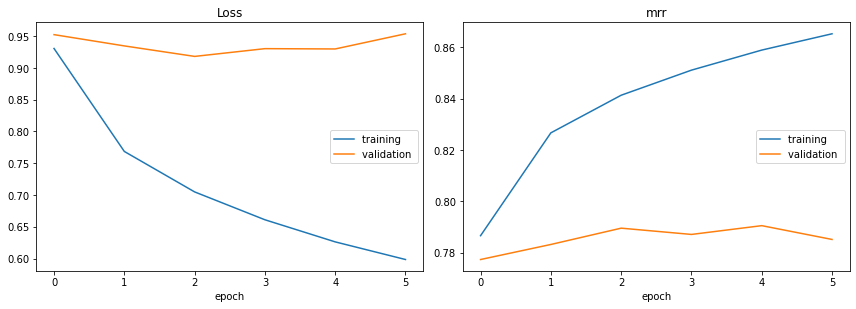

Loss
	training         	 (min:    0.599, max:    0.931, cur:    0.599)
	validation       	 (min:    0.918, max:    0.954, cur:    0.954)
mrr
	training         	 (min:    0.787, max:    0.865, cur:    0.865)
	validation       	 (min:    0.777, max:    0.791, cur:    0.785)


In [ ]:
optimizer = tf.optimizers.Adam()


liveloss = PlotLosses()
logs = {}
epochs = 10
best_val_loss = 100000.0

for epoch in range(epochs):

    # TRAINING
    losses = []
    mrrs = []
    for x in train_ds:
        
        with tf.GradientTape() as tape:
            logits = model(x)
            loss_value = loss_(None, logits)

        mrr_value = mrr(None, logits)

        # calculate gradient
        gradients = tape.gradient(loss_value, model.trainable_variables)

        # Update the weights
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        losses.append(loss_value)
        mrrs.append(mrr_value)

        print(f"Epoch: {epoch}; Loss: {loss_value}; MRR: {mrr_value} <- Train", end="\r")
        
    logs['loss'] = np.mean(losses)
    logs['mrr'] = np.mean(mrrs)
    
    
    # VALIDATION
    losses = []
    mrrs = []
    for x in valid_ds:
        
        logits = model(x)
        
        loss_value = loss_(None, logits)
        mrr_value = mrr(None, logits)
        
        losses.append(loss_value)
        mrrs.append(mrr_value)
        
        print(f"Epoch: {epoch}; Loss: {loss_value}; MRR: {mrr_value} <- Test", end="\r")
        
    logs['val_loss'] = np.mean(losses)
    logs['val_mrr'] = np.mean(mrrs)
    
    if logs['val_loss'] < best_val_loss:
        best_val_loss = logs['val_loss']
        model.save("exp/code_no_ast_embedding_screath_try_bidirectional.h5")
    
    liveloss.update(logs)
    liveloss.send()

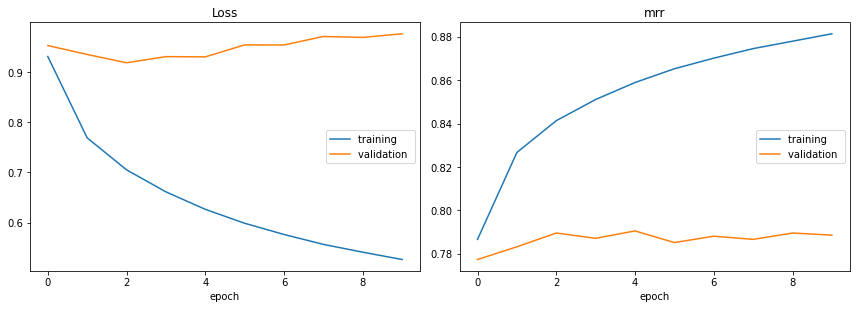

Loss
	training         	 (min:    0.526, max:    0.931, cur:    0.526)
	validation       	 (min:    0.918, max:    0.976, cur:    0.976)
mrr
	training         	 (min:    0.787, max:    0.881, cur:    0.881)
	validation       	 (min:    0.777, max:    0.791, cur:    0.789)


In [22]:
liveloss.send()

In [24]:
model = tf.keras.models.load_model("exp/code_no_ast_embedding_screath_try_bidirectional.h5")

In [25]:
test_ds = get_dataset("test")

In [26]:
    losses = []
    mrrs = []
    for x in get_dataset("test"):
        
        logits = model(x)
        
        loss_value = loss_(None, logits)
        mrr_value = mrr(None, logits)
        
        losses.append(loss_value)
        mrrs.append(mrr_value)
        
        print(f"Epoch: test; Loss: {loss_value}; MRR: {mrr_value} <- Test", end="\r")

In [27]:
np.mean(mrrs)

0.8286

## Predit/Demo

In [ ]:
model = tf.keras.models.load_model("exp/sratch_keras_2.h5")

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 256)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 256)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256)          525312      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 256)          525312      input_2[0][0]                    
Total params: 1,050,624
Trainable params: 1,050,624
Non-trainable params: 0
__________________

In [9]:
query_encoder = tf.keras.models.Model(model.get_layer('input_1').input, model.get_layer('lstm').output)
code_encoder = tf.keras.models.Model(model.get_layer('input_2').input, model.get_layer('lstm_1').output)

In [10]:
test_ds = get_dataset("test")

In [11]:
querys = []
codes = []

for q,c in test_ds:
    querys.extend(query_encoder(q))
    codes.extend(code_encoder(c))

In [21]:
from annoy import AnnoyIndex
import random

t = AnnoyIndex(256, 'angular')
for i in range(len(codes)):
    t.add_item(i, codes[i])

In [24]:
t.on_disk_build("exp/code_no_ast_embedding_screath_try.annoy_on_disk")

True

In [ ]:
t.build(100)

In [12]:
from annoy import AnnoyIndex
t = AnnoyIndex(256, 'angular')
t.load('exp/code_no_ast_embedding_screath_try.annoyme')

True

In [23]:
t.save('exp/code_no_ast_embedding_screath_try.annoyme')

True

In [ ]:
test_df = get_data_df("../resources/data/", ["python"] , ["test"])

In [28]:
result = t.get_nns_by_vector(codes[2155], n=2, include_distances=False)
result

[]

In [17]:
correct = 0 
for i in range(len(querys)):
    result = t.get_nns_by_vector(querys[i], n=10, include_distances=False)
    if i in result:
        correct += 1

Exception: You can't unbuild a loaded index

In [18]:
correct/len(querys)

0.13816738816738816

In [ ]:
with open("../resources/data/python_dedupe_definitions_v2.pkl", "rb") as f:
    import pickle 
    definations = pickle.load(f)